In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mrpython_pcl.LidarPipeline.ConeClassifier import ConeClassifier

import utils

## Predefined Settings

In [2]:
N_SAMPLES = 10 # number of cone samples per distance to generate
MIN_DISTANCE = 0 # METERS
MAX_DISTANCE = 200 # METERS
POSITION_ACCURACY = 0.03 # METERS
HORIZONTAL_FOV = 360 # DEGREES
# VERTICAL FOV
VERTICAL_FOV_MIN = -25 # DEGREES
VERTICAL_FOV_MAX = 15 # DEGREES
#RESOLUTION
VERTICAL_RESOLUTION = 0.33 # DEGREES
HORIZONTAL_RESOLUTION_MIN = 0.1 # DEGREES
HORIZONTAL_RESOLUTION_MAX = 0.4 # DEGREES
# CONE CONSTANTS
CONE_HEIGHT = 0.33 # METERS
CONE_RADIUS = 0.1 # METERS
LIDAR_ORIGIN = (0,0,0.4) # METERS

## Simulate LiDAR Intersections

In [3]:
def simulateLidar(d):
    # sample N_SAMPLES cones
    classifier = ConeClassifier(CONE_RADIUS, CONE_HEIGHT, 1,1,1)
    
    cost_tracker = {'linLoss':[], 'l2Loss':[]}
    
    for i in range(N_SAMPLES):
        cones = []
        angle = np.random.uniform(low=0, high=HORIZONTAL_FOV)
        cone = utils.getConeEquation(angle, d, CONE_HEIGHT, CONE_RADIUS)
        cones.append(cone)
        
        # scan using the lidar
        rotationAngle = np.rad2deg(np.arctan(CONE_RADIUS/d))
        intersections = []
        alpha = angle-rotationAngle
        
        while alpha<=angle+rotationAngle:
            theta = VERTICAL_FOV_MIN
            while theta<=VERTICAL_FOV_MAX:
                # get lidar ray
                ray = utils.getLineEquation(LIDAR_ORIGIN,theta, alpha)
                # get intersection point
                intersection = utils.computeIntersection(cone, ray)
                
                if intersection is not None:
                    if intersection[2]>=0 and intersection[2]<=CONE_HEIGHT:
                        #utils.visualizeLineAndCone(ray[:2],ray[3:5],cone[:2],CONE_RADIUS)
                        #print(intersection)
                        intersection = [np.random.normal(intersection[0], POSITION_ACCURACY), np.random.normal(intersection[1], POSITION_ACCURACY), intersection[2]]
                        intersections.append(intersection)
                theta+=VERTICAL_RESOLUTION
            alpha+=np.random.uniform(low=HORIZONTAL_RESOLUTION_MIN, high=HORIZONTAL_RESOLUTION_MAX)
        
        # use the points to fit the X_c and y_c
        intersections = np.array(intersections)
        
        (_, linLoss, l2Loss), _ = classifier.isCone(intersections, returnLosses=True)
        cost_tracker['linLoss'].append(linLoss)
        
        # compute the sum of cost2
        cost_tracker['l2Loss'].append(l2Loss)
        
                    
    # compute the mean and std of sigma_cost1 and sigma_cost2
    thres1_mean = np.mean(cost_tracker['linLoss'])
    thres1_std = np.std(cost_tracker['linLoss'])
    thres2_mean = np.mean(cost_tracker['l2Loss'])
    thres2_std = np.std(cost_tracker['l2Loss'])
    
    return thres1_mean, thres1_std, thres2_mean, thres2_std, cost_tracker

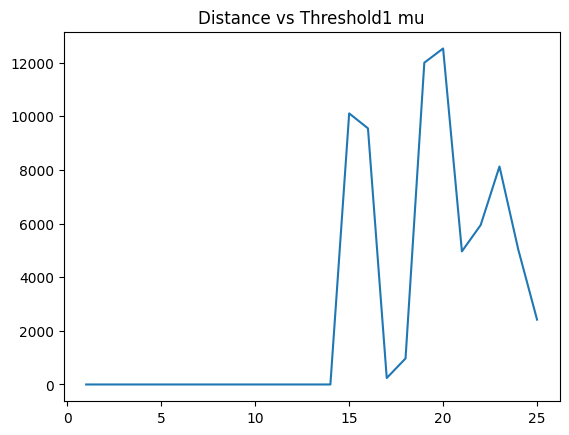

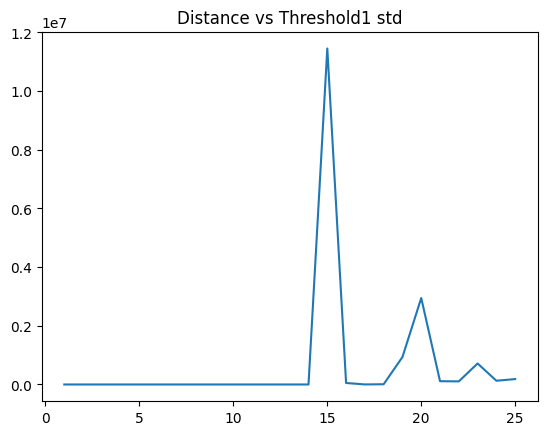

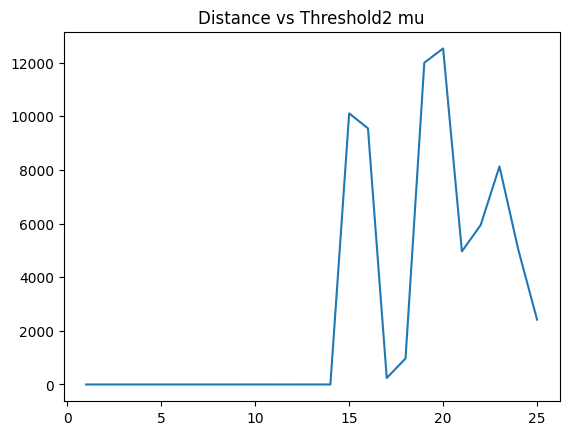

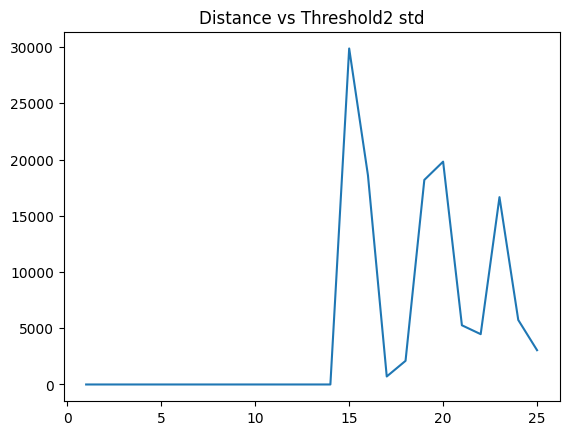

In [4]:
# simulate on many distances
t1MUList = []
t1STDList = []
t2MUList = []
t2STDList = []

for i in range(1,25+1):
    t1MU, t1STD, t1MU, t2STD,_ = simulateLidar(i)
    t1MUList.append(t1MU)
    t1STDList.append(t1STD)
    t2MUList.append(t1MU)
    t2STDList.append(t2STD)

distance_list = np.arange(1,25+1)
plt.plot(distance_list, t1MUList)
plt.title('Distance vs Threshold1 mu')
plt.show()
plt.plot(distance_list, t1STDList)
plt.title('Distance vs Threshold1 std')
plt.show()
plt.plot(distance_list, t2MUList)
plt.title('Distance vs Threshold2 mu')
plt.show()
plt.plot(distance_list, t2STDList)
plt.title('Distance vs Threshold2 std')
plt.show()

In [5]:
thres1_mean, thres1_std, thres2_mean, thres2_std,_ = simulateLidar(1)
thres1_mean, thres1_std, thres2_mean, thres2_std

(6.074820984704474e-06,
 5.862980540909096e-07,
 0.016377620809918714,
 0.001337976223424527)